# Band Importance

## Goal

The goal of the first experiment is to find the best combination of bands. We choose from all bands available in the Sentinel-2 [Level-2A](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) product and all indices derived from those bands offered by the [eemont](https://github.com/davemlz/eemont) package.

## Methodology

The experiment is conducted as follows:

- We create one composite raster per area with all potential bands is created by averaging across the year of recording.
- Random Forest from scikit-learn with default parameters is chosen as the classification model.
- Recursive Feature Elimination (RFE) is used to select the best 10 bands.

We start with listing all available bands and indices:

In [1]:
# List all available Sentinel-2 Level-2A bands
from logging import INFO
from sys import stdout

from loguru import logger

from slc.data import list_bands

logger.configure(handlers=[{"sink": stdout, "format": "{message}", "level": INFO}])

bands = list_bands()

logger.info(f"All available Level-2A Bands: {bands}")

All available Level-2A Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


In [2]:
# List all available indices offered by eemont
from slc.data import list_indices

indices = list_indices()

logger.info(f"All applicable indices offered by eemont: {indices}")

All applicable indices offered by eemont: ['AFRI1600', 'AFRI2100', 'ANDWI', 'ARI', 'ARI2', 'ARVI', 'ATSAVI', 'AVI', 'AWEInsh', 'AWEIsh', 'BAI', 'BAIM', 'BAIS2', 'BCC', 'BI', 'BITM', 'BIXS', 'BLFEI', 'BNDVI', 'BRBA', 'BWDRVI', 'BaI', 'CIG', 'CIRE', 'CSI', 'CVI', 'DBSI', 'DSI', 'DSWI1', 'DSWI2', 'DSWI3', 'DSWI4', 'DSWI5', 'DVI', 'DVIplus', 'EMBI', 'EVI', 'EVI2', 'ExG', 'ExGR', 'ExR', 'FCVI', 'GARI', 'GBNDVI', 'GCC', 'GDVI', 'GEMI', 'GLI', 'GM1', 'GM2', 'GNDVI', 'GOSAVI', 'GRNDVI', 'GRVI', 'GSAVI', 'GVMI', 'IAVI', 'IBI', 'IKAW', 'IPVI', 'IRECI', 'LSWI', 'MBI', 'MBWI', 'MCARI', 'MCARI1', 'MCARI2', 'MCARI705', 'MCARIOSAVI', 'MCARIOSAVI705', 'MGRVI', 'MIRBI', 'MLSWI26', 'MLSWI27', 'MNDVI', 'MNDWI', 'MNLI', 'MRBVI', 'MSAVI', 'MSI', 'MSR', 'MSR705', 'MTCI', 'MTVI1', 'MTVI2', 'MuWIR', 'NBAI', 'NBR', 'NBR2', 'NBRSWIR', 'NBRplus', 'NBSIMS', 'ND705', 'NDBI', 'NDCI', 'NDDI', 'NDGI', 'NDGlaI', 'NDII', 'NDMI', 'NDPI', 'NDPonI', 'NDREI', 'NDSI', 'NDSII', 'NDSInw', 'NDSWIR', 'NDSaII', 'NDSoI', 'NDTI', 

We create one raster per study area with all potential bands and indices by averaging across the year of recording:

In [3]:
# Create a composite from a Sentinel image with all available bands and indices
from datetime import datetime
from pathlib import Path
from zoneinfo import ZoneInfo

import rasterio
from tqdm.notebook import tqdm

from slc.data import sentinel_composite

tz = ZoneInfo("CET")

# Define the label path as well as the path to write the raster to
target_folder = Path("../data/processed/target/")
data_folder = Path("../data/processed/band_importance/data/")

# Create the 2A composite if it does not exist
data_folder.mkdir(parents=True, exist_ok=True)
for target_path in tqdm(tuple(target_folder.glob("*.tif"))):
    data_path = data_folder / target_path.name
    year = int(target_path.stem.split("_")[-1])

    if not data_path.exists():
        try:
            sentinel_composite(
                target_path_from=target_path,
                data_path_to=data_path,
                time_window=(
                    datetime(year, 1, 1, tzinfo=tz),
                    datetime(year + 1, 1, 1, tzinfo=tz),
                ),
                sentinel_bands=bands,
                indices=indices,
            )
        except KeyboardInterrupt as exc:
            raise KeyboardInterrupt from exc
        except Exception:  # noqa: BLE001
            # Download composite in two steps if it fails
            sentinel_composite(
                target_path_from=target_path,
                data_path_to="tmp.tif",
                time_window=(
                    datetime(year, 1, 1, tzinfo=tz),
                    datetime(year + 1, 1, 1, tzinfo=tz),
                ),
                sentinel_bands=bands,
                indices=indices[: len(indices) // 2],
            )

            sentinel_composite(
                target_path_from=target_path,
                data_path_to="tmp2.tif",
                time_window=(
                    datetime(year, 1, 1, tzinfo=tz),
                    datetime(year + 1, 1, 1, tzinfo=tz),
                ),
                sentinel_bands=[],
                indices=indices[len(indices) // 2 :],
            )

            with rasterio.open("tmp.tif") as src1, rasterio.open("tmp2.tif") as src2:
                profile = src1.profile
                profile.update(count=src1.count + src2.count)
                descriptions = src1.descriptions + src2.descriptions
                with rasterio.open(data_path, "w", **profile) as dst:
                    for i in range(1, src1.count + 1):
                        dst.write(src1.read(i), i)
                    for i in range(1, src2.count + 1):
                        dst.write(src2.read(i), src1.count + i)

                    dst.descriptions = descriptions

            Path("tmp.tif").unlink()
            Path("tmp2.tif").unlink()

            logger.debug(f"Created composite in two steps for {target_path}")

  0%|          | 0/48 [00:00<?, ?it/s]

The whole dataset is loaded, consisting of the target rasters created in the previous step and the Sentinel-2 bands and indices composited above. We perform recursive feature elimination to select the 10 best bands and indices. Each RFE iteration is evaluated using stratified 5-fold cross-validation:

In [4]:
# Compute the scores for each step of the RFE
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate
from tqdm.notebook import tqdm

from slc.data import split_band_name
from slc.features import load_dataset

# Check if the report is already available
band_importance_path = "../reports/band_importance.csv"
if not Path(band_importance_path).exists():
    Path(band_importance_path).parent.mkdir(parents=True, exist_ok=True)

    # Load the dataset
    data, target = load_dataset(data_folder, target_folder)

    # Create the RFE object and rank each pixel
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)
    rfe = RFE(estimator=rf, n_features_to_select=1, step=1, verbose=1)
    rfe.fit(data, target)

    # Define the scoring metrics
    scoring = {
        "F1 Score": make_scorer(f1_score),
        "Accuracy": make_scorer(accuracy_score),
        "Kappa": make_scorer(cohen_kappa_score),
    }

    # Get the features in reverse order of elimination
    ranking = rfe.ranking_
    feature_names = rfe.feature_names_in_
    order_index = ranking.argsort()
    ordered_features = feature_names[order_index]

    # Compute the score for each step of the RFE
    score_df = pd.DataFrame(columns=scoring.keys())
    for i in tqdm(range(ordered_features.shape[0])):
        # Fit the model with the current features
        curr_data = data[ordered_features[: i + 1]]
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_validate(
            rf, curr_data, target, cv=cv, scoring=scoring, n_jobs=-1
        )

        # Store the score in the dataframe
        band_label = split_band_name(ordered_features[i])[1]
        score_df.loc[band_label] = [scores[f"test_{key}"].mean() for key in scoring]

    # Save the scores to a CSV file
    score_df.to_csv(band_importance_path, index_label="Band")
    score_df.index.name = "Band"
else:
    # Load the scores from the CSV file
    score_df = pd.read_csv(band_importance_path, index_col=0)

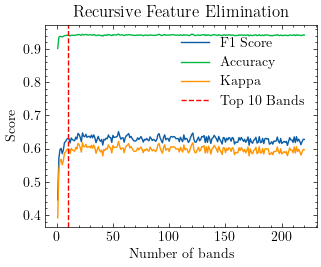

In [5]:
# Plot the RFE scores for n bands
import matplotlib.pyplot as plt
import scienceplots  # noqa: F401

from slc.visualize import save_fig

# Use science style for plots
plt.style.use("science")

# Plot RFE scores
fig, ax = plt.subplots()
score_df["Index"] = range(1, score_df.shape[0] + 1)
score_df.plot(x="Index", y="F1 Score", label="F1 Score", ax=ax)
score_df.plot(x="Index", y="Accuracy", label="Accuracy", ax=ax)
score_df.plot(x="Index", y="Kappa", label="Kappa", ax=ax)
ax.axvline(10, color="red", linestyle="--", label="Top 10 Bands")

# Format the plot
ax.set_title("Recursive Feature Elimination")
ax.set_xlabel("Number of bands")
ax.set_ylabel("Score")
ax.legend()

save_fig(fig, f"../reports/figures/band_importance/{ax.get_title()}.svg")

## Result

The F1 Score, Accuracy, and Kappa do not improve significantly when keeping more than 10 bands, see the plot above. Additionally we generally want to keep the number of bands as low as possible to reduce the complexity of data retrieval and processing. Thus we choose following 10 best bands and indices for subsequent experiments:

In [6]:
# List all selected bands and indices
from slc.models import bands_from_importance

sentinel_bands, index_bands = bands_from_importance(band_importance_path, top_n=10)

logger.info(f"Level-2A bands: {sentinel_bands}")
logger.info(f"Indices: {index_bands}")

Level-2A bands: ['B11', 'B12']
Indices: ['BRBA', 'GDVI', 'MIRBI', 'MLSWI26', 'MLSWI27', 'MRBVI', 'NBAI', 'SWI']


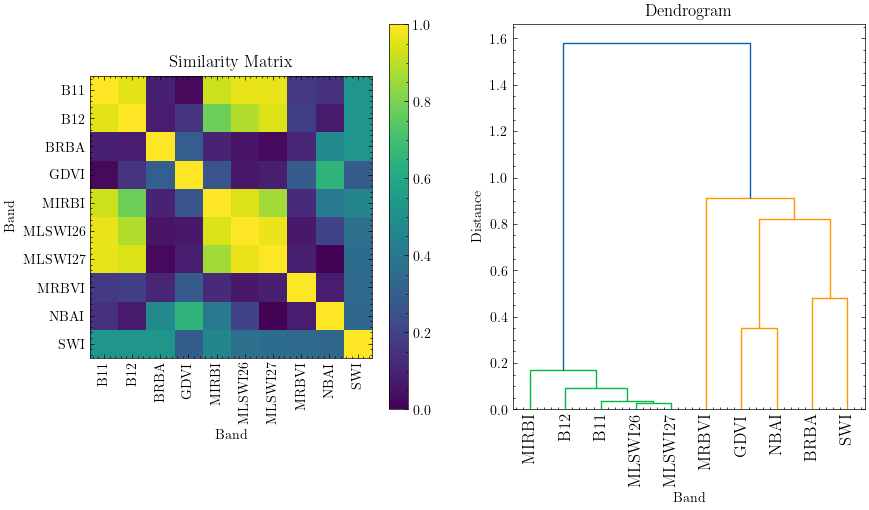

In [7]:
from slc.data import split_band_name
from slc.features import (
    get_similarity_matrix,
    load_dataset,
    show_dendrogram,
    show_similarity_matrix,
)

data, target = load_dataset(data_folder, target_folder)
bands = [
    band
    for band in data.columns
    if split_band_name(band)[1] in sentinel_bands + index_bands
]
data = data[bands]
data.columns = [split_band_name(band)[1] for band in data.columns]

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sm = get_similarity_matrix(data)
show_similarity_matrix(sm, ax=axs[0])
show_dendrogram(sm, ax=axs[1])

save_fig(fig, "../reports/figures/band_importance/Similarity Matrix and Dendrogram.svg")

The similarity matrix and dendrogram for the top 10 selected bands and indices reveal minimal correlation between most of them. This indicates that each band captures unique information, contributing to a more diverse and information rich dataset.